# Momentum Strategies vs HRP: Comprehensive Analysis

This notebook evaluates momentum-based strategies against the previous winner (HRP):

**New Momentum Strategies:**
- CrossSectionalMomentum (CS_MOM)
- TimeSeriesMomentum (TS_MOM)
- RiskManagedMomentum (RM_MOM)
- MomentumHRP (MOM_HRP) - Combined approach

**Baseline Comparison:**
- HRP (Previous Winner)
- IVP, MVP
- HODL BTC/ETH

**Data Sources:**
- Primary: Binance API
- Alternative: CoinGecko API

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.portfolio_maker import (
    HRP, IVP, MVP,
    CrossSectionalMomentum, TimeSeriesMomentum,
    RiskManagedMomentum, MomentumHRP
)
from src.agent import PortfolioChangeAnalyzerUSD

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Color scheme
COLORS = {
    'HRP': '#3498db',      # Blue (baseline winner)
    'IVP': '#95a5a6',      # Gray
    'MVP': '#7f8c8d',      # Dark gray
    'CS_MOM': '#2ecc71',   # Green
    'TS_MOM': '#27ae60',   # Dark green
    'RM_MOM': '#1abc9c',   # Teal
    'MOM_HRP': '#e74c3c',  # Red (highlight combined)
    'HODL_BTC': '#f39c12', # Orange
    'HODL_ETH': '#9b59b6'  # Purple
}

## 1. Comprehensive Metrics Functions

In [3]:
def calculate_portfolio_returns(returns_matrix, weights):
    """Calculate portfolio returns."""
    aligned_weights = weights.reindex(returns_matrix.columns).fillna(0)
    return (returns_matrix * aligned_weights).sum(axis=1)

def calculate_cumulative_returns(returns_matrix, weights):
    """Calculate cumulative returns."""
    portfolio_returns = calculate_portfolio_returns(returns_matrix, weights)
    return (1 + portfolio_returns).cumprod()

# Basic metrics
def calculate_total_return(cumulative_returns):
    return (cumulative_returns.iloc[-1] - 1) * 100

def calculate_annualized_return(cumulative_returns, periods_per_year=365):
    n_periods = len(cumulative_returns)
    total_return = cumulative_returns.iloc[-1]
    return (total_return ** (periods_per_year / n_periods) - 1) * 100

def calculate_annualized_volatility(returns, periods_per_year=365):
    return returns.std() * np.sqrt(periods_per_year) * 100

def calculate_sharpe_ratio(returns, risk_free_rate=0, periods_per_year=365):
    if returns.std() == 0:
        return 0
    excess_returns = returns - risk_free_rate/periods_per_year
    return np.sqrt(periods_per_year) * (excess_returns.mean() / returns.std())

def calculate_sortino_ratio(returns, risk_free_rate=0, periods_per_year=365):
    excess_returns = returns - risk_free_rate/periods_per_year
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0 or np.sqrt(np.mean(downside_returns**2)) == 0:
        return np.inf
    downside_std = np.sqrt(np.mean(downside_returns**2))
    return np.sqrt(periods_per_year) * (excess_returns.mean() / downside_std)

def calculate_max_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.expanding().max()
    drawdowns = cumulative_returns/rolling_max - 1
    return drawdowns.min() * 100

def calculate_calmar_ratio(cumulative_returns, periods_per_year=365):
    ann_return = calculate_annualized_return(cumulative_returns, periods_per_year)
    max_dd = abs(calculate_max_drawdown(cumulative_returns))
    if max_dd == 0:
        return np.inf
    return ann_return / max_dd

# Advanced metrics
def calculate_var(returns, confidence=0.95):
    """Value at Risk (historical)."""
    return np.percentile(returns, (1 - confidence) * 100) * 100

def calculate_cvar(returns, confidence=0.95):
    """Conditional Value at Risk (Expected Shortfall)."""
    var = np.percentile(returns, (1 - confidence) * 100)
    return returns[returns <= var].mean() * 100

def calculate_skewness(returns):
    """Return distribution skewness."""
    return stats.skew(returns.dropna())

def calculate_kurtosis(returns):
    """Return distribution kurtosis (excess)."""
    return stats.kurtosis(returns.dropna())

def calculate_win_rate(returns):
    """Percentage of positive return days."""
    return (returns > 0).sum() / len(returns) * 100

def calculate_profit_factor(returns):
    """Ratio of gross profits to gross losses."""
    gains = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    if losses == 0:
        return np.inf
    return gains / losses

def calculate_ulcer_index(cumulative_returns):
    """Ulcer Index - measure of downside volatility."""
    rolling_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns / rolling_max - 1) * 100
    return np.sqrt(np.mean(drawdowns**2))

def calculate_turnover(old_weights, new_weights):
    """Portfolio turnover."""
    all_assets = old_weights.index.union(new_weights.index)
    old = old_weights.reindex(all_assets).fillna(0)
    new = new_weights.reindex(all_assets).fillna(0)
    return np.abs(new - old).sum()

def calculate_effective_n(weights):
    """Effective number of assets (1/HHI)."""
    hhi = (weights**2).sum()
    if hhi == 0:
        return 0
    return 1 / hhi

def calculate_all_metrics(portfolio_returns, cumulative_returns, weights=None):
    """Calculate all performance metrics."""
    metrics = {
        # Return metrics
        'Total Return (%)': calculate_total_return(cumulative_returns),
        'Annualized Return (%)': calculate_annualized_return(cumulative_returns),
        # Risk metrics
        'Annualized Vol (%)': calculate_annualized_volatility(portfolio_returns),
        'Max Drawdown (%)': calculate_max_drawdown(cumulative_returns),
        'VaR 95% (%)': calculate_var(portfolio_returns, 0.95),
        'CVaR 95% (%)': calculate_cvar(portfolio_returns, 0.95),
        'Ulcer Index': calculate_ulcer_index(cumulative_returns),
        # Risk-adjusted returns
        'Sharpe Ratio': calculate_sharpe_ratio(portfolio_returns),
        'Sortino Ratio': calculate_sortino_ratio(portfolio_returns),
        'Calmar Ratio': calculate_calmar_ratio(cumulative_returns),
        # Distribution metrics
        'Skewness': calculate_skewness(portfolio_returns),
        'Kurtosis': calculate_kurtosis(portfolio_returns),
        'Win Rate (%)': calculate_win_rate(portfolio_returns),
        'Profit Factor': calculate_profit_factor(portfolio_returns),
    }
    
    if weights is not None:
        metrics['Effective N'] = calculate_effective_n(weights)
        metrics['Max Weight (%)'] = weights.max() * 100
        metrics['N Assets'] = (weights > 0.001).sum()
    
    return metrics

## 2. Load Data (Binance)

In [5]:
# Load Binance data
data = pd.read_csv(os.path.join('..', 'data', 'binance_usdt_pairs_2018-12-31_2024-01-01_1d.csv'))
data['open_time'] = pd.to_datetime(data['open_time'])
print(f"Binance data: {data.shape[0]:,} rows, {data['symbol'].nunique()} symbols")

# Filter stablecoins
stablecoin_pairs = [
    'USDCUSDT', 'BUSDUSDT', 'DAIUSDT', 'TUSDUSDT', 'USDPUSDT',
    'GUSDUSDT', 'FDUSDT', 'PYUSDUSDT', 'LUSDUSDT', 'USDSUSDT',
    'SUSDUSDT', 'CUSDUSDT', 'USDXUSDT', 'FRAXUSDT', 'USDDUSDT',
    'FDUSDUSDT', 'PAXUSDT', 'USDSBUSDT'
]
filtered_data = data[~data['symbol'].isin(stablecoin_pairs)]
filtered_data = filtered_data.sort_values(by='open_time').reset_index(drop=True)
print(f"After filtering: {filtered_data['symbol'].nunique()} symbols")

Binance data: 76,653 rows, 50 symbols
After filtering: 50 symbols


In [6]:
# Configuration
WINDOW_SIZE = 365 * 2  # 2 years training
REBALANCING_DAYS = 30  # Monthly rebalancing

# Momentum parameters (crypto-optimized)
FORMATION_PERIOD = 21
HOLDING_PERIOD = 7
TOP_PERCENTILE = 0.3
BOTTOM_PERCENTILE = 0.2

print(f"Training window: {WINDOW_SIZE} days")
print(f"Rebalancing: every {REBALANCING_DAYS} days")
print(f"Momentum lookback: {FORMATION_PERIOD} days")

Training window: 730 days
Rebalancing: every 30 days
Momentum lookback: 21 days


In [7]:
# Prepare training returns
returns = (
    filtered_data
    .pivot(columns='symbol', values='close', index='open_time')
    .iloc[:WINDOW_SIZE+1]
    .pct_change(fill_method=None)
    .iloc[1:]
    .dropna(axis=1, how='any')
)
print(f"Training returns: {returns.shape[0]} days, {returns.shape[1]} assets")

Training returns: 730 days, 13 assets


## 3. Strategy Initialization

In [8]:
def get_all_strategies(returns_df):
    """Initialize all portfolio strategies."""
    return {
        # Baseline (previous winner)
        'HRP': HRP(returns_df),
        'IVP': IVP(returns_df),
        'MVP': MVP(returns_df),
        # New momentum strategies
        'CS_MOM': CrossSectionalMomentum(
            returns_df, formation_period=FORMATION_PERIOD,
            top_percentile=TOP_PERCENTILE, bottom_percentile=BOTTOM_PERCENTILE,
            weighting_scheme='equal'
        ),
        'TS_MOM': TimeSeriesMomentum(
            returns_df, signal_type='ma_crossover',
            fast_period=7, slow_period=28, position_sizing='equal'
        ),
        'RM_MOM': RiskManagedMomentum(
            returns_df, formation_period=FORMATION_PERIOD,
            vol_lookback=63, target_volatility=0.12,
            top_percentile=TOP_PERCENTILE
        ),
        'MOM_HRP': MomentumHRP(
            returns_df, formation_period=FORMATION_PERIOD,
            top_percentile=0.4, min_assets=5
        )
    }

# Get initial weights
strategies = get_all_strategies(returns)
initial_weights = {name: strat.get_weights() for name, strat in strategies.items()}

print("Initial weights summary:")
print("-" * 50)
for name, w in initial_weights.items():
    eff_n = calculate_effective_n(w)
    print(f"{name:10s}: {(w>0.001).sum():3d} assets, Eff.N={eff_n:.1f}, max={w.max()*100:.1f}%")

Initial weights summary:
--------------------------------------------------
HRP       :  13 assets, Eff.N=12.2, max=11.2%
IVP       :  13 assets, Eff.N=12.3, max=13.4%
MVP       :   6 assets, Eff.N=2.8, max=52.7%
CS_MOM    :   3 assets, Eff.N=3.0, max=33.3%
TS_MOM    :   6 assets, Eff.N=6.0, max=16.7%
RM_MOM    :   3 assets, Eff.N=3.0, max=33.3%
MOM_HRP   :   5 assets, Eff.N=4.2, max=33.5%


## 4. Static Portfolio Comparison (vs HRP Baseline)

In [9]:
# Test data
test_returns = (
    filtered_data
    .pivot(columns='symbol', values='close', index='open_time')
    .iloc[WINDOW_SIZE:]
    .pct_change(fill_method=None)
    .iloc[1:]
)
test_returns = test_returns[returns.columns]
print(f"Test period: {test_returns.index[0].date()} to {test_returns.index[-1].date()}")
print(f"Test returns: {test_returns.shape[0]} days")

Test period: 2021-01-01 to 2024-01-01
Test returns: 1096 days


In [10]:
# Calculate static performance
static_cum = {}
static_ret = {}

for name, weights in initial_weights.items():
    static_ret[name] = calculate_portfolio_returns(test_returns, weights)
    static_cum[name] = calculate_cumulative_returns(test_returns, weights)

# Add HODL benchmarks
hodl_btc = pd.Series({'BTCUSDT': 1.0})
hodl_eth = pd.Series({'ETHUSDT': 1.0})
static_ret['HODL_BTC'] = calculate_portfolio_returns(test_returns, hodl_btc)
static_ret['HODL_ETH'] = calculate_portfolio_returns(test_returns, hodl_eth)
static_cum['HODL_BTC'] = calculate_cumulative_returns(test_returns, hodl_btc)
static_cum['HODL_ETH'] = calculate_cumulative_returns(test_returns, hodl_eth)

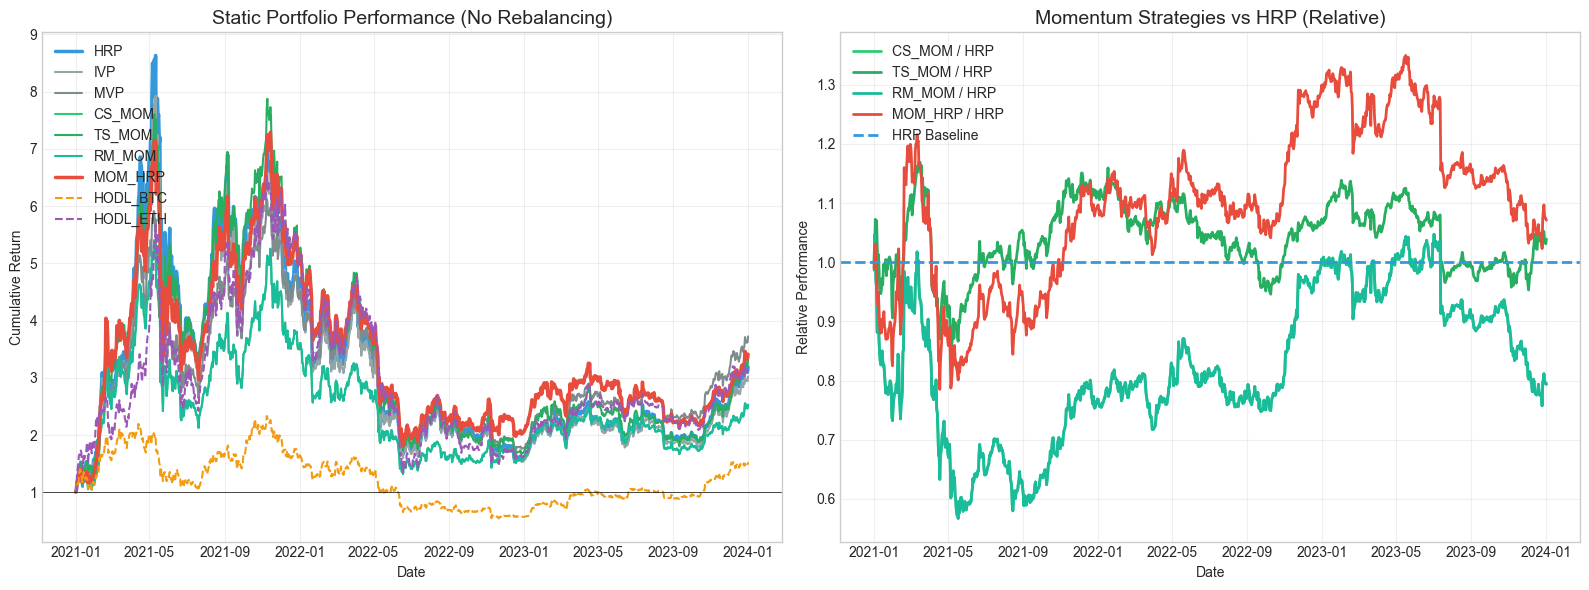

In [11]:
# Plot: Cumulative Returns vs HRP Baseline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: All strategies
ax1 = axes[0]
for name, cum in static_cum.items():
    color = COLORS.get(name, '#333333')
    linewidth = 2.5 if name in ['HRP', 'MOM_HRP'] else 1.5
    ax1.plot(cum.index, cum, label=name, color=color, linewidth=linewidth,
            linestyle='--' if 'HODL' in name else '-')

ax1.set_title('Static Portfolio Performance (No Rebalancing)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='black', linestyle='-', linewidth=0.5)

# Right: Momentum strategies vs HRP (relative performance)
ax2 = axes[1]
hrp_cum = static_cum['HRP']
for name in ['CS_MOM', 'TS_MOM', 'RM_MOM', 'MOM_HRP']:
    relative = static_cum[name] / hrp_cum
    ax2.plot(relative.index, relative, label=f'{name} / HRP', 
            color=COLORS[name], linewidth=2)

ax2.axhline(y=1, color='#3498db', linestyle='--', linewidth=2, label='HRP Baseline')
ax2.set_title('Momentum Strategies vs HRP (Relative)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Relative Performance')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/static_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Calculate all metrics
static_metrics = {}
for name in static_cum.keys():
    weights = initial_weights.get(name)
    static_metrics[name] = calculate_all_metrics(static_ret[name], static_cum[name], weights)

metrics_df = pd.DataFrame(static_metrics).T
print("\nStatic Portfolio Metrics (No Rebalancing):")
print("=" * 80)
display(metrics_df.round(2))


Static Portfolio Metrics (No Rebalancing):


,Total Return (%),Annualized Return (%),Annualized Vol (%),Max Drawdown (%),VaR 95% (%),CVaR 95% (%),Ulcer Index,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Skewness,Kurtosis,Win Rate (%),Profit Factor,Effective N,Max Weight (%),N Assets
HRP,218.8200,47.1300,81.8100,-81.9500,-6.7800,-10.1800,62.1700,0.8900,0.8500,0.5800,-0.3900,6.0800,54.0100,1.1500,12.2100,11.1700,13.0000
IVP,202.7100,44.6100,80.1200,-80.9300,-6.7400,-10.0200,60.9900,0.8700,0.8300,0.5500,-0.4100,5.9700,54.1100,1.1400,12.2700,13.4200,13.0000
MVP,272.5700,54.9600,70.7600,-71.6000,-5.6800,-8.6700,49.1400,0.9700,0.9800,0.7700,-0.0400,5.6800,52.2800,1.1600,2.8100,52.6900,6.0000
CS_MOM,153.0300,36.2300,75.8600,-75.6000,-6.0500,-9.4200,53.7200,0.7900,0.7800,0.4800,-0.0200,7.4500,52.6500,1.1300,3.0000,33.3300,3.0000
TS_MOM,231.3000,49.0200,79.2800,-78.9700,-6.4400,-9.8300,57.8600,0.9000,0.8800,0.6200,-0.3100,5.0700,53.6500,1.1500,6.0000,16.6700,6.0000
RM_MOM,153.0300,36.2300,75.8600,-75.6000,-6.0500,-9.4200,53.7200,0.7900,0.7800,0.4800,-0.0200,7.4500,52.6500,1.1300,3.0000,33.3300,3.0000
MOM_HRP,241.4900,50.5300,77.4800,-75.0600,-6.3200,-9.4900,53.3300,0.9200,0.9000,0.6700,-0.0700,7.0100,54.3800,1.1500,4.2000,33.5200,5.0000
HODL_BTC,52.7500,15.1500,64.8600,-76.6300,-5.5900,-7.9400,50.5100,0.5400,0.5700,0.2000,0.1000,3.4400,48.9100,1.0900,NaN,NaN,NaN
HODL_ETH,219.3900,47.2200,84.6800,-79.3000,-6.5500,-10.1000,52.4400,0.8800,0.9100,0.6000,0.0800,5.0400,51.3700,1.1400,NaN,NaN,NaN


In [13]:
# Comparison vs HRP baseline
hrp_sharpe = static_metrics['HRP']['Sharpe Ratio']
hrp_return = static_metrics['HRP']['Total Return (%)']

print("\nComparison vs HRP (Previous Winner):")
print("=" * 60)
for name in ['CS_MOM', 'TS_MOM', 'RM_MOM', 'MOM_HRP']:
    sharpe_diff = static_metrics[name]['Sharpe Ratio'] - hrp_sharpe
    return_diff = static_metrics[name]['Total Return (%)'] - hrp_return
    print(f"{name:10s}: Sharpe {sharpe_diff:+.2f} vs HRP, Return {return_diff:+.1f}% vs HRP")


Comparison vs HRP (Previous Winner):
CS_MOM    : Sharpe -0.10 vs HRP, Return -65.8% vs HRP
TS_MOM    : Sharpe +0.02 vs HRP, Return +12.5% vs HRP
RM_MOM    : Sharpe -0.10 vs HRP, Return -65.8% vs HRP
MOM_HRP   : Sharpe +0.03 vs HRP, Return +22.7% vs HRP


## 5. Dynamic Backtesting with Rebalancing

In [14]:
# Initialize tracking
strategy_names = ['HRP', 'IVP', 'MVP', 'CS_MOM', 'TS_MOM', 'RM_MOM', 'MOM_HRP']

current_weights = {name: initial_weights[name].copy() for name in strategy_names}
all_weights_history = {name: [initial_weights[name].copy()] for name in strategy_names}
total_turnover = {name: 0.0 for name in strategy_names}
total_costs = {name: 0.0 for name in strategy_names}
rebalance_count = {name: 0 for name in strategy_names}
all_portfolio_returns = {name: [] for name in strategy_names}

In [15]:
# Run backtest
n_days = len(filtered_data['open_time'].unique())
total_periods = (n_days - WINDOW_SIZE - REBALANCING_DAYS) // REBALANCING_DAYS
print(f"Running {total_periods} rebalancing periods...")

for period in range(total_periods):
    window_start = period * REBALANCING_DAYS
    window_end = window_start + WINDOW_SIZE
    backtest_end = window_end + REBALANCING_DAYS
    
    # Training returns
    period_returns = (
        filtered_data
        .pivot(columns='symbol', values='close', index='open_time')
        .iloc[window_start:window_end+1]
        .pct_change(fill_method=None)
        .iloc[1:]
        .dropna(axis=1, how='any')
    )
    
    # Backtest returns
    backtest_returns = (
        filtered_data
        .pivot(columns='symbol', values='close', index='open_time')
        .iloc[window_end:backtest_end+1]
        .pct_change(fill_method=None)
        .iloc[1:]
    )
    
    # New weights
    new_strategies = get_all_strategies(period_returns)
    new_weights = {name: strat.get_weights() for name, strat in new_strategies.items()}
    
    # Process each strategy
    for name in strategy_names:
        # Analyze transition
        analyzer = PortfolioChangeAnalyzerUSD(
            current_weights[name], new_weights[name],
            period_returns, transaction_cost_rate=0.001
        )
        analysis = analyzer.analyze_transition(min_improvement_threshold=None)
        
        # Track turnover
        turnover = calculate_turnover(current_weights[name], new_weights[name])
        total_turnover[name] += turnover
        total_costs[name] += analysis['transaction_costs']
        rebalance_count[name] += 1
        
        # Update weights
        current_weights[name] = new_weights[name].copy()
        all_weights_history[name].append(new_weights[name].copy())
        
        # Calculate returns
        aligned_returns = backtest_returns.reindex(columns=current_weights[name].index).fillna(0)
        port_ret = calculate_portfolio_returns(aligned_returns, current_weights[name])
        all_portfolio_returns[name].append(port_ret)
    
    if (period + 1) % 10 == 0:
        print(f"  Period {period+1}/{total_periods}")

print("Backtest complete!")

Running 35 rebalancing periods...
  Period 10/35
  Period 20/35
  Period 30/35
Backtest complete!


In [16]:
# Combine returns
dynamic_ret = {}
dynamic_cum = {}

for name in strategy_names:
    combined = pd.concat(all_portfolio_returns[name])
    dynamic_ret[name] = combined
    dynamic_cum[name] = (1 + combined).cumprod()

print(f"Test period: {dynamic_cum['HRP'].index[0].date()} to {dynamic_cum['HRP'].index[-1].date()}")

Test period: 2021-01-01 to 2023-11-16


## 6. Comprehensive Results Analysis

In [17]:
# Dynamic metrics
dynamic_metrics = {}
for name in strategy_names:
    metrics = calculate_all_metrics(dynamic_ret[name], dynamic_cum[name], current_weights[name])
    metrics['Avg Turnover'] = total_turnover[name] / rebalance_count[name]
    metrics['Total Costs (%)'] = total_costs[name] * 100
    metrics['Rebalances'] = rebalance_count[name]
    dynamic_metrics[name] = metrics

dyn_metrics_df = pd.DataFrame(dynamic_metrics).T
print("\nDynamic Portfolio Metrics (With 30-day Rebalancing):")
print("=" * 80)
display(dyn_metrics_df.round(2))


Dynamic Portfolio Metrics (With 30-day Rebalancing):


,Total Return (%),Annualized Return (%),Annualized Vol (%),Max Drawdown (%),VaR 95% (%),CVaR 95% (%),Ulcer Index,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Skewness,Kurtosis,Win Rate (%),Profit Factor,Effective N,Max Weight (%),N Assets,Avg Turnover,Total Costs (%),Rebalances
HRP,118.6000,31.2400,87.4500,-81.7500,-7.5200,-10.9200,58.7700,0.7600,0.7100,0.3800,-0.4900,5.7700,55.1400,1.1200,40.2900,6.2900,50.0000,0.2000,0.7000,35.0000
IVP,120.9600,31.7300,86.0100,-81.6000,-7.4400,-10.7900,59.1000,0.7600,0.7000,0.3900,-0.4800,5.6100,55.4300,1.1200,41.7500,5.3900,50.0000,0.0700,0.2500,35.0000
MVP,200.2300,46.5500,68.5900,-73.8300,-5.5300,-8.3600,48.7500,0.9000,0.9100,0.6300,0.1200,5.0800,52.7600,1.1500,3.2400,39.5600,6.0000,0.1700,0.5800,35.0000
CS_MOM,121.0700,31.7500,92.5400,-80.5500,-7.4800,-11.2000,57.1000,0.7600,0.7500,0.3900,-0.0100,6.5200,54.0000,1.1200,15.0000,6.6700,15.0000,1.3700,4.8100,35.0000
TS_MOM,108.5000,29.1000,95.4300,-84.9300,-7.9400,-11.5200,65.0100,0.7500,0.7300,0.3400,-0.0900,5.4900,53.7100,1.1200,4.0000,25.0000,4.0000,1.5100,5.2900,35.0000
RM_MOM,121.0700,31.7500,92.5400,-80.5500,-7.4800,-11.2000,57.1000,0.7600,0.7500,0.3900,-0.0100,6.5200,54.0000,1.1200,15.0000,6.6700,15.0000,1.3700,4.8100,35.0000
MOM_HRP,289.5500,60.4300,91.0400,-76.0500,-7.4700,-11.1000,52.2100,0.9800,0.9400,0.7900,-0.1600,5.7100,55.2400,1.1600,14.0600,13.9800,20.0000,1.2800,4.5000,35.0000


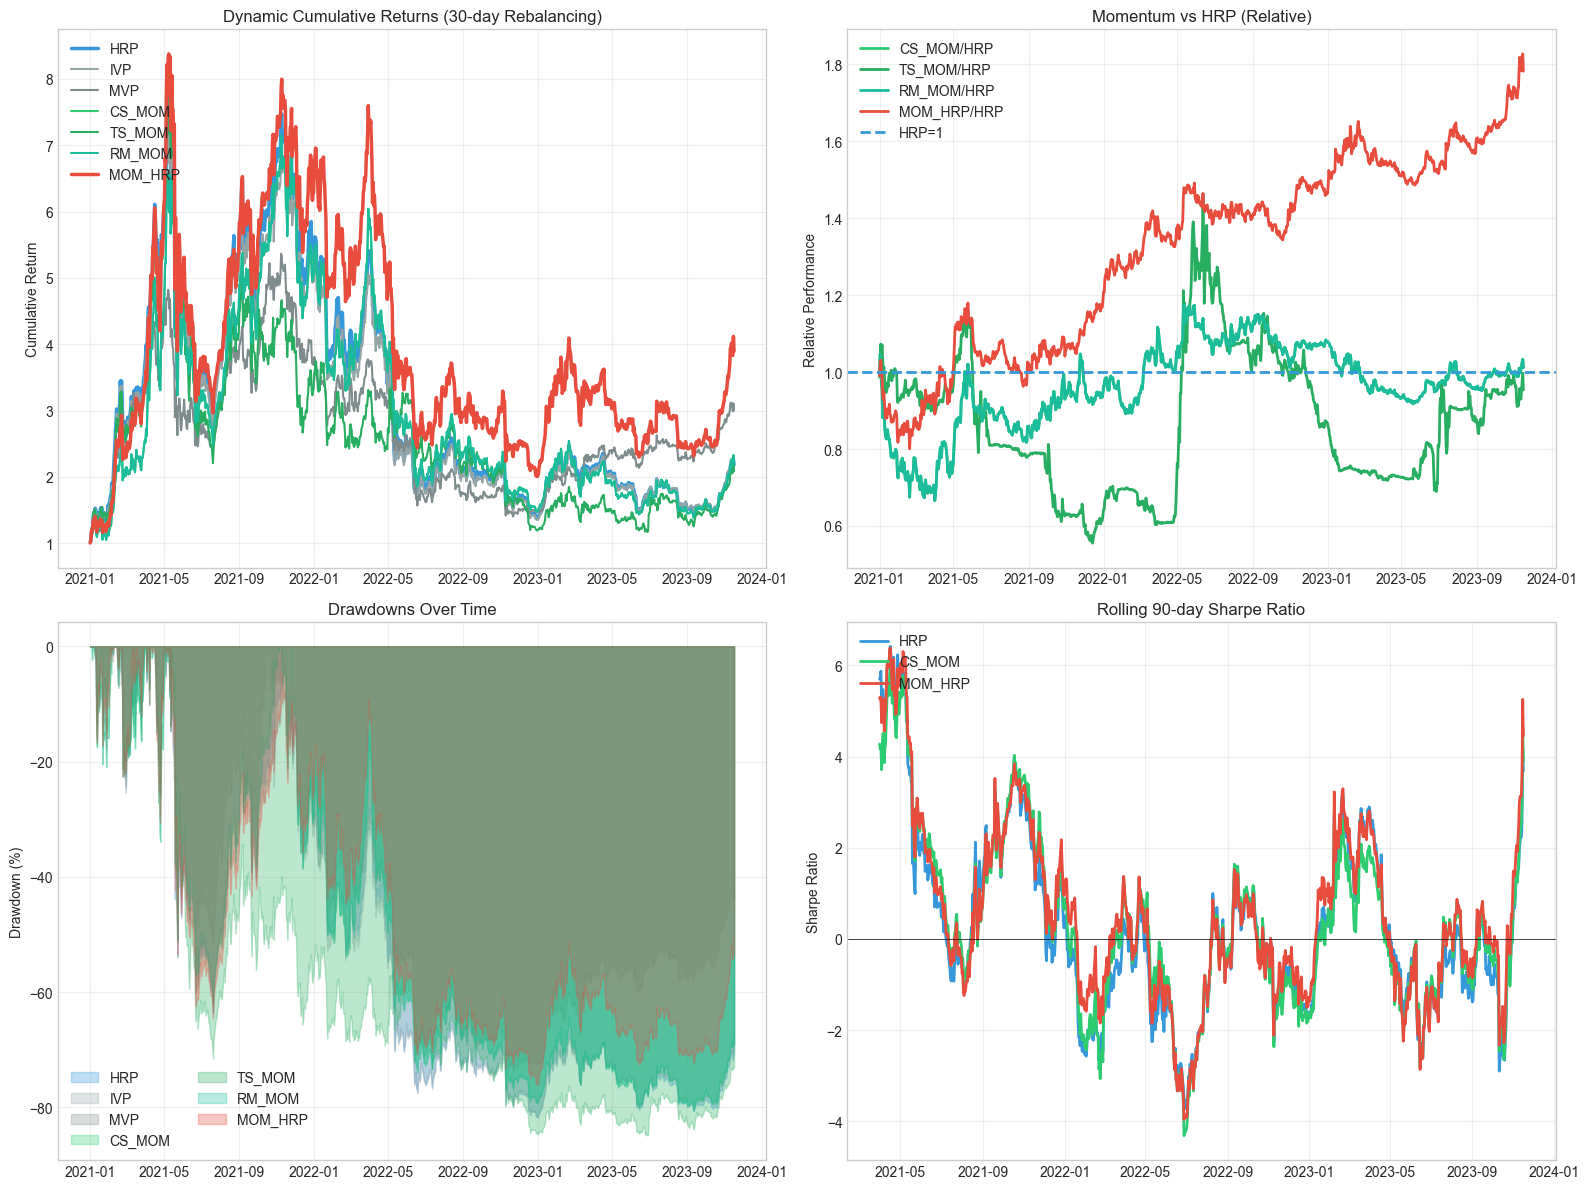

In [18]:
# Plot: Dynamic cumulative returns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative returns
ax1 = axes[0, 0]
for name in strategy_names:
    ax1.plot(dynamic_cum[name].index, dynamic_cum[name], 
            label=name, color=COLORS[name], 
            linewidth=2.5 if name in ['HRP', 'MOM_HRP'] else 1.5)
ax1.set_title('Dynamic Cumulative Returns (30-day Rebalancing)', fontsize=12)
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Relative to HRP
ax2 = axes[0, 1]
for name in ['CS_MOM', 'TS_MOM', 'RM_MOM', 'MOM_HRP']:
    relative = dynamic_cum[name] / dynamic_cum['HRP']
    ax2.plot(relative.index, relative, label=f'{name}/HRP', color=COLORS[name], linewidth=2)
ax2.axhline(y=1, color='#3498db', linestyle='--', linewidth=2, label='HRP=1')
ax2.set_title('Momentum vs HRP (Relative)', fontsize=12)
ax2.set_ylabel('Relative Performance')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Drawdowns
ax3 = axes[1, 0]
for name in strategy_names:
    rolling_max = dynamic_cum[name].expanding().max()
    drawdown = (dynamic_cum[name] / rolling_max - 1) * 100
    ax3.fill_between(drawdown.index, drawdown, 0, alpha=0.3, 
                    color=COLORS[name], label=name)
ax3.set_title('Drawdowns Over Time', fontsize=12)
ax3.set_ylabel('Drawdown (%)')
ax3.legend(loc='lower left', ncol=2)
ax3.grid(True, alpha=0.3)

# 4. Rolling Sharpe (90-day)
ax4 = axes[1, 1]
for name in ['HRP', 'CS_MOM', 'MOM_HRP']:
    rolling_ret = dynamic_ret[name].rolling(90).mean() * 365
    rolling_vol = dynamic_ret[name].rolling(90).std() * np.sqrt(365)
    rolling_sharpe = rolling_ret / rolling_vol
    ax4.plot(rolling_sharpe.index, rolling_sharpe, label=name, 
            color=COLORS[name], linewidth=2)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_title('Rolling 90-day Sharpe Ratio', fontsize=12)
ax4.set_ylabel('Sharpe Ratio')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/dynamic_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Turnover and Cost Analysis

In [19]:
# Turnover comparison
turnover_df = pd.DataFrame({
    'Strategy': strategy_names,
    'Total Turnover': [total_turnover[n] for n in strategy_names],
    'Avg Turnover': [total_turnover[n]/rebalance_count[n] for n in strategy_names],
    'Total Costs (%)': [total_costs[n]*100 for n in strategy_names],
    'Cost-Adjusted Return (%)': [dynamic_metrics[n]['Total Return (%)'] - total_costs[n]*100 
                                  for n in strategy_names]
})

print("Turnover Analysis:")
print("=" * 60)
display(turnover_df.round(4))

Turnover Analysis:


,Strategy,Total Turnover,Avg Turnover,Total Costs (%),Cost-Adjusted Return (%)
0,HRP,7.0340,0.2010,0.7034,117.8992
1,IVP,2.5036,0.0715,0.2504,120.7049
2,MVP,5.8351,0.1667,0.5835,199.6510
3,CS_MOM,48.0915,1.3740,4.8091,116.2620
4,TS_MOM,52.8802,1.5109,5.2880,103.2082
5,RM_MOM,48.0915,1.3740,4.8091,116.2620
6,MOM_HRP,44.9698,1.2849,4.4970,285.0485


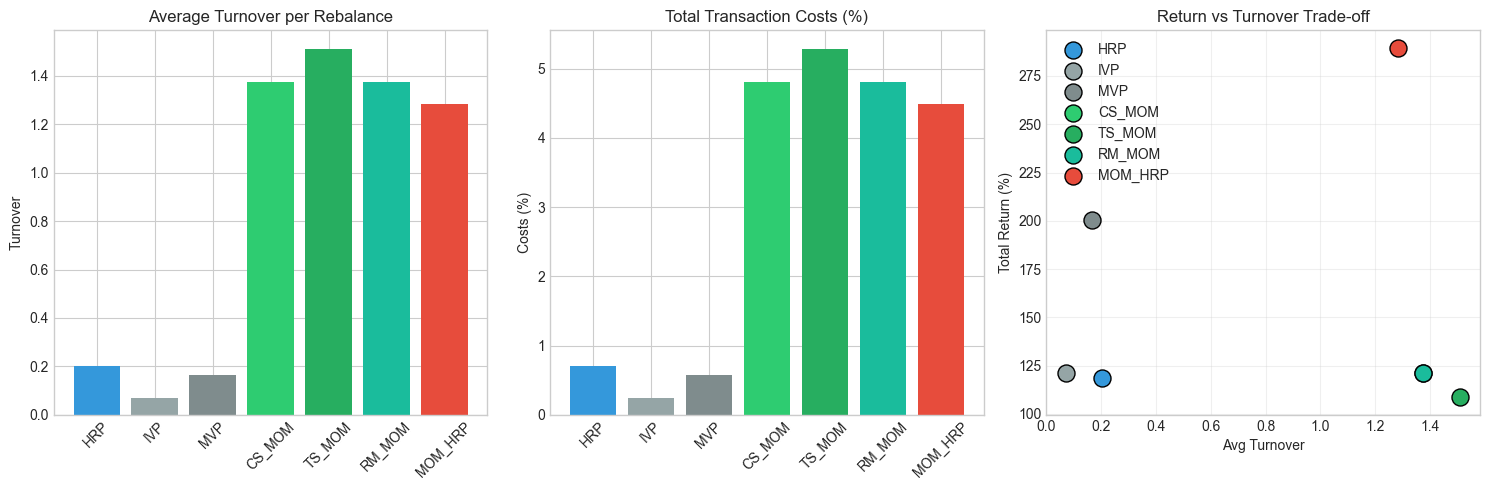

In [20]:
# Plot: Turnover comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = [COLORS[n] for n in strategy_names]

# Avg turnover
axes[0].bar(strategy_names, turnover_df['Avg Turnover'], color=colors)
axes[0].set_title('Average Turnover per Rebalance')
axes[0].set_ylabel('Turnover')
axes[0].tick_params(axis='x', rotation=45)

# Total costs
axes[1].bar(strategy_names, turnover_df['Total Costs (%)'], color=colors)
axes[1].set_title('Total Transaction Costs (%)')
axes[1].set_ylabel('Costs (%)')
axes[1].tick_params(axis='x', rotation=45)

# Return vs Turnover scatter
returns = [dynamic_metrics[n]['Total Return (%)'] for n in strategy_names]
turnovers = [total_turnover[n]/rebalance_count[n] for n in strategy_names]
for i, name in enumerate(strategy_names):
    axes[2].scatter(turnovers[i], returns[i], s=150, c=colors[i], label=name, edgecolors='black')
axes[2].set_xlabel('Avg Turnover')
axes[2].set_ylabel('Total Return (%)')
axes[2].set_title('Return vs Turnover Trade-off')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/turnover_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Risk-Return Analysis

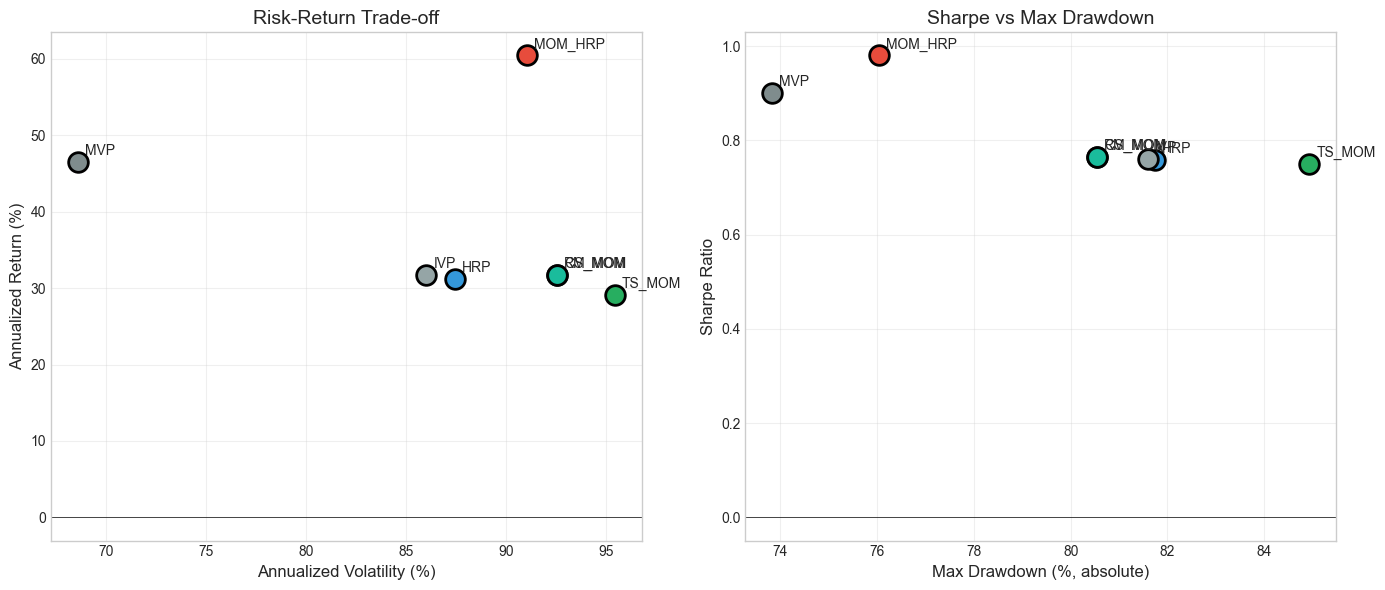

In [21]:
# Risk-return scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Volatility vs Return
ax1 = axes[0]
for name in strategy_names:
    ret = dynamic_metrics[name]['Annualized Return (%)']
    vol = dynamic_metrics[name]['Annualized Vol (%)']
    ax1.scatter(vol, ret, s=200, c=COLORS[name], label=name, edgecolors='black', linewidths=2)
    ax1.annotate(name, (vol, ret), xytext=(5, 5), textcoords='offset points', fontsize=10)

ax1.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax1.set_ylabel('Annualized Return (%)', fontsize=12)
ax1.set_title('Risk-Return Trade-off', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Right: Max Drawdown vs Sharpe
ax2 = axes[1]
for name in strategy_names:
    sharpe = dynamic_metrics[name]['Sharpe Ratio']
    mdd = abs(dynamic_metrics[name]['Max Drawdown (%)'])
    ax2.scatter(mdd, sharpe, s=200, c=COLORS[name], label=name, edgecolors='black', linewidths=2)
    ax2.annotate(name, (mdd, sharpe), xytext=(5, 5), textcoords='offset points', fontsize=10)

ax2.set_xlabel('Max Drawdown (%, absolute)', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Sharpe vs Max Drawdown', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../paper/risk_return.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Return Distribution Analysis

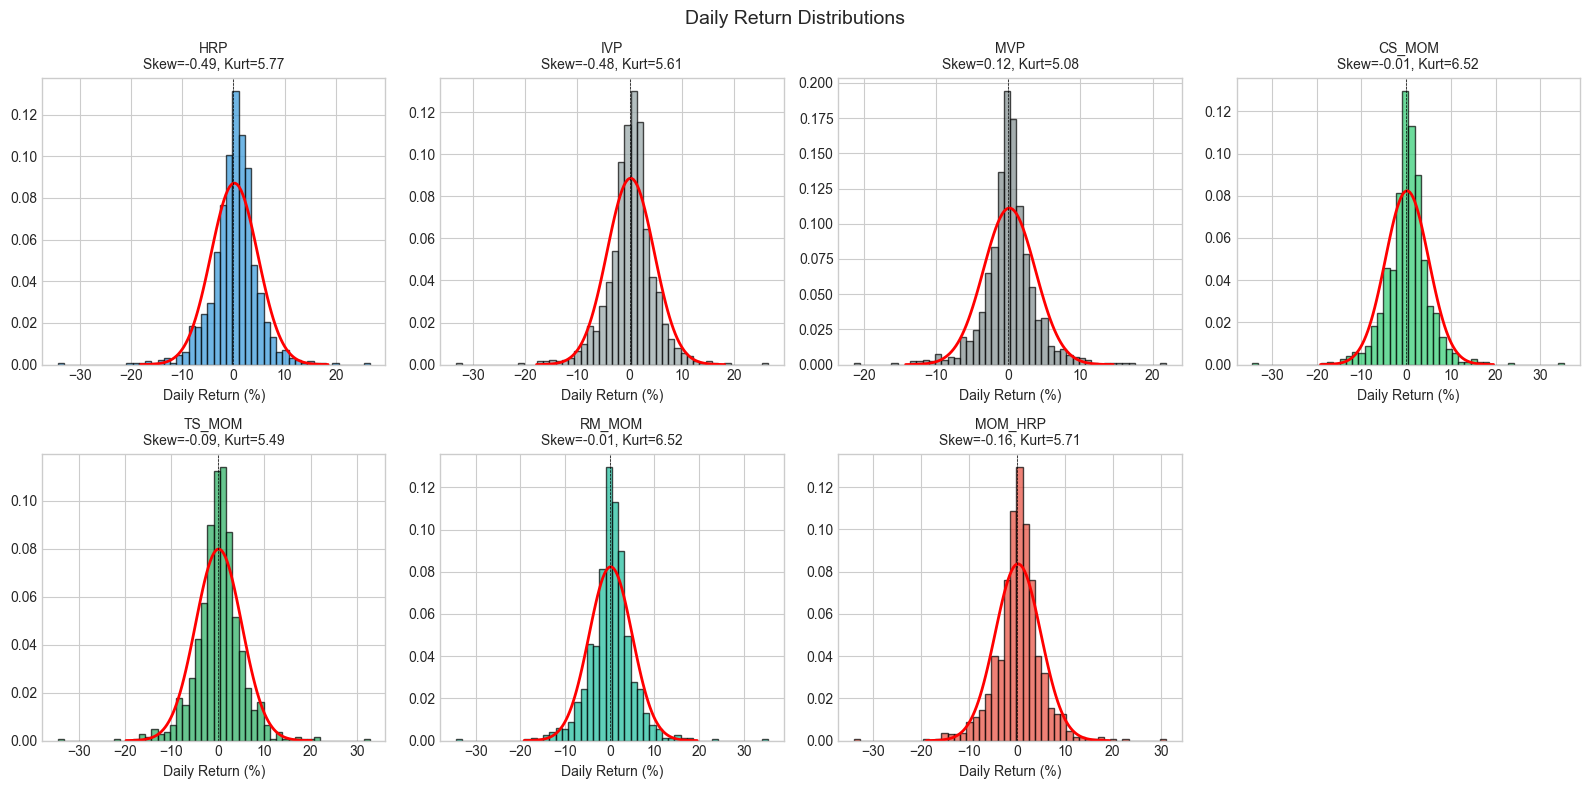

In [22]:
# Return distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, name in enumerate(strategy_names):
    ax = axes[idx // 4, idx % 4]
    returns = dynamic_ret[name].dropna()
    
    # Histogram
    ax.hist(returns * 100, bins=50, density=True, alpha=0.7, color=COLORS[name], edgecolor='black')
    
    # Add normal distribution overlay
    mu, std = returns.mean() * 100, returns.std() * 100
    x = np.linspace(mu - 4*std, mu + 4*std, 100)
    ax.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normal')
    
    # Stats
    skew = calculate_skewness(returns)
    kurt = calculate_kurtosis(returns)
    ax.set_title(f'{name}\nSkew={skew:.2f}, Kurt={kurt:.2f}', fontsize=10)
    ax.set_xlabel('Daily Return (%)')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

# Hide last subplot
axes[1, 3].axis('off')

plt.suptitle('Daily Return Distributions', fontsize=14)
plt.tight_layout()
plt.savefig('../paper/return_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Weight Concentration Analysis

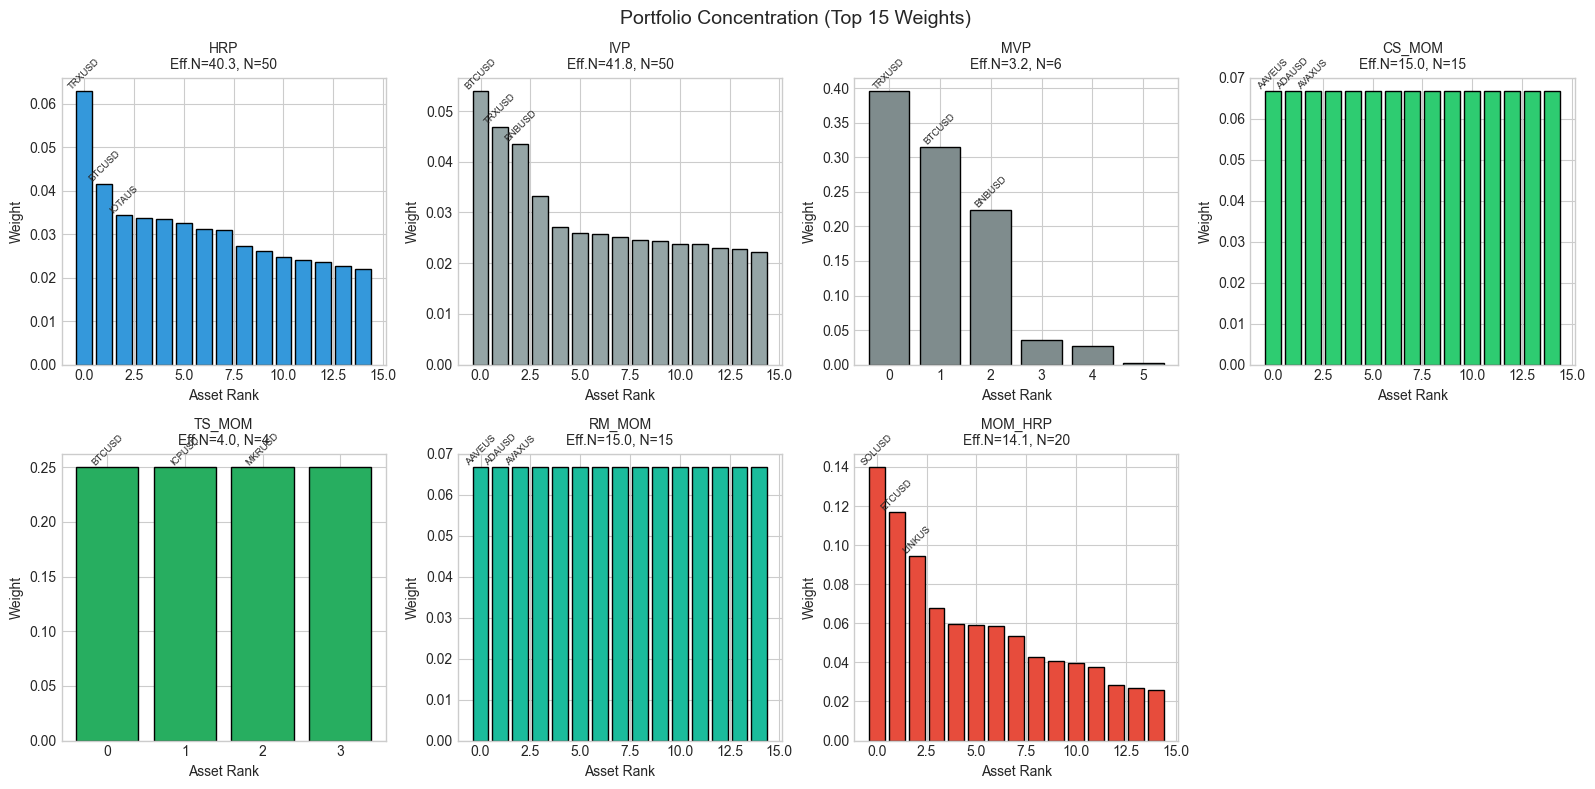

In [23]:
# Final weights comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, name in enumerate(strategy_names):
    ax = axes[idx // 4, idx % 4]
    w = current_weights[name]
    w_sorted = w[w > 0.001].sort_values(ascending=False)
    
    # Top 15 weights
    top_15 = w_sorted.head(15)
    bars = ax.bar(range(len(top_15)), top_15.values, color=COLORS[name], edgecolor='black')
    
    # Add labels for top 3
    for i in range(min(3, len(top_15))):
        ax.text(i, top_15.values[i], top_15.index[i][:6], 
               ha='center', va='bottom', fontsize=7, rotation=45)
    
    eff_n = calculate_effective_n(w)
    ax.set_title(f'{name}\nEff.N={eff_n:.1f}, N={len(w_sorted)}', fontsize=10)
    ax.set_xlabel('Asset Rank')
    ax.set_ylabel('Weight')

# Hide last subplot
axes[1, 3].axis('off')

plt.suptitle('Portfolio Concentration (Top 15 Weights)', fontsize=14)
plt.tight_layout()
plt.savefig('../paper/weight_concentration.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Metrics Heatmap Comparison

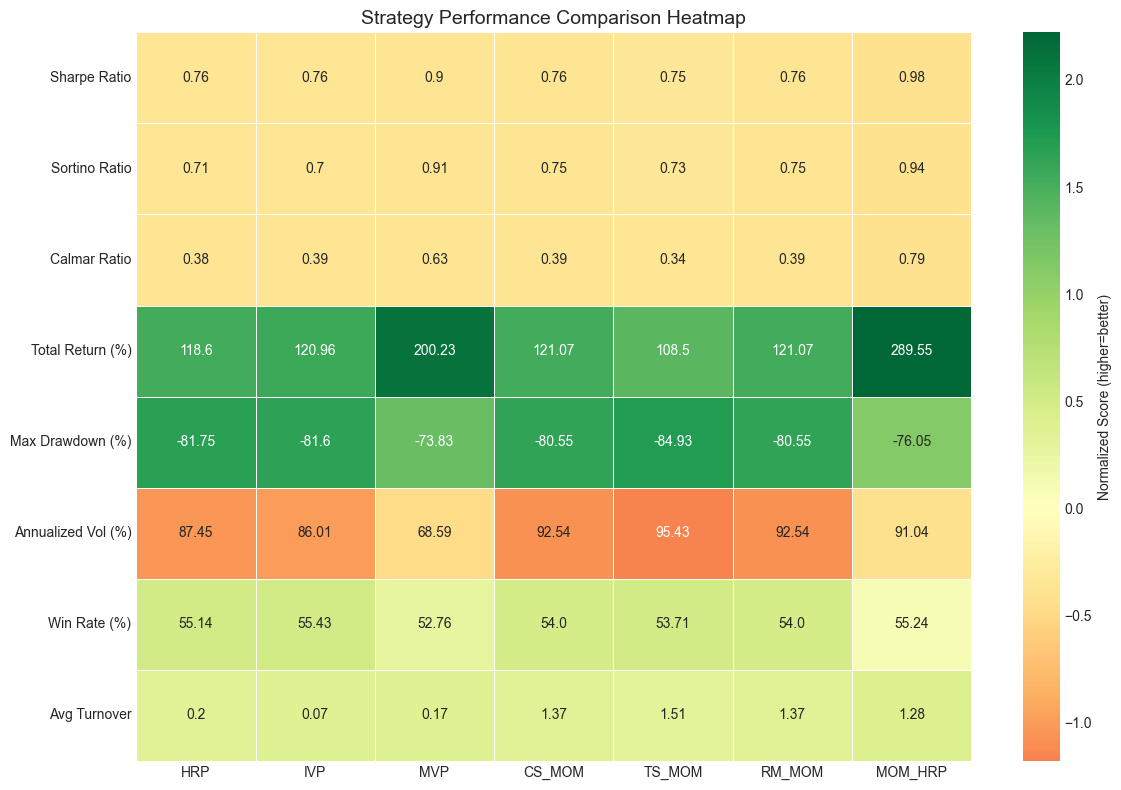

In [24]:
# Metrics heatmap
key_metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 
               'Total Return (%)', 'Max Drawdown (%)', 'Annualized Vol (%)',
               'Win Rate (%)', 'Avg Turnover']

heatmap_data = dyn_metrics_df[key_metrics].T

# Normalize for heatmap (higher is better, except for Vol, DD, Turnover)
heatmap_norm = heatmap_data.copy()
for col in heatmap_norm.columns:
    heatmap_norm[col] = (heatmap_norm[col] - heatmap_norm[col].mean()) / heatmap_norm[col].std()

# Invert "bad" metrics
for metric in ['Max Drawdown (%)', 'Annualized Vol (%)', 'Avg Turnover']:
    if metric in heatmap_norm.index:
        heatmap_norm.loc[metric] = -heatmap_norm.loc[metric]

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_norm, annot=heatmap_data.round(2), fmt='', 
           cmap='RdYlGn', center=0, ax=ax, linewidths=0.5,
           cbar_kws={'label': 'Normalized Score (higher=better)'})
ax.set_title('Strategy Performance Comparison Heatmap', fontsize=14)
plt.tight_layout()
plt.savefig('../paper/metrics_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Final Summary

In [25]:
print("="*80)
print("BACKTEST SUMMARY: MOMENTUM STRATEGIES vs HRP")
print("="*80)
print(f"\nData Source: Binance")
print(f"Test Period: {dynamic_cum['HRP'].index[0].date()} to {dynamic_cum['HRP'].index[-1].date()}")
print(f"Rebalancing: Every {REBALANCING_DAYS} days")
print(f"Training Window: {WINDOW_SIZE} days")
print(f"\nMomentum Parameters:")
print(f"  Formation: {FORMATION_PERIOD} days")
print(f"  Top Percentile: {TOP_PERCENTILE*100}%")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Best by each metric
print("\nBest by Sharpe Ratio:")
sharpe_ranking = dyn_metrics_df['Sharpe Ratio'].sort_values(ascending=False)
for i, (name, val) in enumerate(sharpe_ranking.head(3).items()):
    print(f"  {i+1}. {name}: {val:.3f}")

print("\nBest by Sortino Ratio:")
sortino_ranking = dyn_metrics_df['Sortino Ratio'].sort_values(ascending=False)
for i, (name, val) in enumerate(sortino_ranking.head(3).items()):
    print(f"  {i+1}. {name}: {val:.3f}")

print("\nLowest Max Drawdown:")
dd_ranking = dyn_metrics_df['Max Drawdown (%)'].sort_values(ascending=False)
for i, (name, val) in enumerate(dd_ranking.head(3).items()):
    print(f"  {i+1}. {name}: {val:.1f}%")

print("\nLowest Turnover:")
turnover_ranking = dyn_metrics_df['Avg Turnover'].sort_values()
for i, (name, val) in enumerate(turnover_ranking.head(3).items()):
    print(f"  {i+1}. {name}: {val:.3f}")

print("\n" + "="*80)
print("MOMENTUM vs HRP COMPARISON")
print("="*80)
hrp_sharpe = dynamic_metrics['HRP']['Sharpe Ratio']
for name in ['CS_MOM', 'TS_MOM', 'RM_MOM', 'MOM_HRP']:
    sharpe = dynamic_metrics[name]['Sharpe Ratio']
    diff = sharpe - hrp_sharpe
    pct_change = (diff / abs(hrp_sharpe)) * 100 if hrp_sharpe != 0 else 0
    symbol = "✓" if diff > 0 else "✗"
    print(f"{symbol} {name:10s}: Sharpe={sharpe:.3f} ({diff:+.3f} vs HRP, {pct_change:+.1f}%)")

BACKTEST SUMMARY: MOMENTUM STRATEGIES vs HRP

Data Source: Binance
Test Period: 2021-01-01 to 2023-11-16
Rebalancing: Every 30 days
Training Window: 730 days

Momentum Parameters:
  Formation: 21 days
  Top Percentile: 30.0%

KEY FINDINGS

Best by Sharpe Ratio:
  1. MOM_HRP: 0.980
  2. MVP: 0.900
  3. CS_MOM: 0.765

Best by Sortino Ratio:
  1. MOM_HRP: 0.942
  2. MVP: 0.914
  3. CS_MOM: 0.745

Lowest Max Drawdown:
  1. MVP: -73.8%
  2. MOM_HRP: -76.0%
  3. CS_MOM: -80.5%

Lowest Turnover:
  1. IVP: 0.072
  2. MVP: 0.167
  3. HRP: 0.201

MOMENTUM vs HRP COMPARISON
✓ CS_MOM    : Sharpe=0.765 (+0.007 vs HRP, +0.9%)
✗ TS_MOM    : Sharpe=0.750 (-0.008 vs HRP, -1.0%)
✓ RM_MOM    : Sharpe=0.765 (+0.007 vs HRP, +0.9%)
✓ MOM_HRP   : Sharpe=0.980 (+0.222 vs HRP, +29.3%)


In [26]:
# Save results to CSV
dyn_metrics_df.to_csv('../data/momentum_backtest_results.csv')
print("\nResults saved to data/momentum_backtest_results.csv")


Results saved to data/momentum_backtest_results.csv
